# 여행 상품 신청 여부 예측 경진대회
https://dacon.io/competitions/official/235959/data


https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/3-4-%EC%98%81%ED%99%94-%EB%A6%AC%EB%B7%B0-%EB%B6%84%EB%A5%98-%EC%9D%B4%EC%A7%84-%EB%B6%84%EB%A5%98-%EC%98%88%EC%A0%9C/

### ~8/28
- 각자 전처리한 데이터에 대해 모델 공부(3~4개) + 모델 적용까지
- 결측치, 이상치 전처리 통일은 다음주 회의에서 진행

<br>

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

**X**<br>

id : 샘플 아이디<br>
Age : 나이<br>
TypeofContact : 고객의 제품 인지 방법 (회사의 홍보 or 스스로 검색)<br>
CityTier : 주거 중인 도시의 등급. (인구, 시설, 생활 수준 기준) (1등급 > 2등급 > 3등급) <br>
DurationOfPitch : 영업 사원이 고객에게 제공하는 프레젠테이션 기간<br>
Occupation : 직업<br>
Gender : 성별<br>
NumberOfPersonVisiting : 고객과 함께 여행을 계획 중인 총 인원 **여행인원수**<br>
NumberOfFollowups : 영업 사원의 프레젠테이션 후 이루어진 후속 조치 수<br>
ProductPitched : 영업 사원이 제시한 상품<br>
PreferredPropertyStar : 선호 호텔 숙박업소 등급<br>
MaritalStatus : 결혼여부<br>
NumberOfTrips : 평균 연간 여행 횟수<br>
Passport : 여권 보유 여부 (0: 없음, 1: 있음)<br>
PitchSatisfactionScore : 영업 사원의 프레젠테이션 만족도<br>
OwnCar : 자동차 보유 여부 (0: 없음, 1: 있음)<br>
NumberOfChildrenVisiting : 함께 여행을 계획 중인 5세 미만의 어린이 수<br>
Designation : (직업의) 직급<br>
MonthlyIncome : 월 급여<br>

**y**<br>

ProdTaken : 여행 패키지 신청 여부 (0: 신청 안 함, 1: 신청함) → test데이터에는 없음

In [182]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

<br>

### train 전처리

In [183]:
##결측치
# 1. Age (평균)
train['Age'].fillna(train['Age'].mean(), inplace=True)
# 2. TypeofContact (unknown)
train['TypeofContact'].fillna('unknown', inplace=True)
# 3. DurationOfPitch (최빈값)
train['DurationOfPitch'].fillna(9, inplace=True)
# 4. NumberOfFollowups (최빈값)
train['NumberOfFollowups'].fillna(4, inplace=True)
# 5. PreferredPropertyStar (최빈값)
train['PreferredPropertyStar'].fillna(3, inplace=True)
# 6.NumberOfTrips (평균 내림)
train['NumberOfTrips'].fillna(3, inplace=True)
# 7. NumberOfChildrenVisiting (최빈값)
train['NumberOfChildrenVisiting'].fillna(1, inplace=True)
# 8. MonthlyIncome (평균)
train['MonthlyIncome'].fillna(train['MonthlyIncome'].mean(), inplace=True)


##이상치
# 1. NumberOfTrips (제일 큰 이상치 제거)
train = train.drop(train[train['NumberOfTrips']>15].index)
# 2. MonthlyIncome (제일 크거나 작은 이상치 제거)
train = train.drop(train[train['MonthlyIncome']>=80000].index)
train = train.drop(train[train['MonthlyIncome']<=13327.75].index)

##문자형 변수
# 1. Gender
train['Gender'].replace('Fe Male', 'Female', inplace = True)
# 2. 더미변수화
train = pd.get_dummies(train, columns = ['TypeofContact', 'Occupation','Gender',
                                         'ProductPitched','MaritalStatus','Designation'])

# id 제거
train = train.drop(columns=['id'])

### test 전처리

In [184]:
##결측치
# 1. Age (평균)
test['Age'].fillna(test['Age'].mean(), inplace=True)
# 2. TypeofContact (unknown)
test['TypeofContact'].fillna('unknown', inplace=True)
# 3. DurationOfPitch (최빈값)
test['DurationOfPitch'].fillna(9, inplace=True)
# 4. NumberOfFollowups (최빈값)
test['NumberOfFollowups'].fillna(4, inplace=True)
# 5. PreferredPropertyStar (최빈값)
test['PreferredPropertyStar'].fillna(3, inplace=True)
# 6.NumberOfTrips (평균 내림)
test['NumberOfTrips'].fillna(3, inplace=True)
# 7. NumberOfChildrenVisiting (최빈값)
test['NumberOfChildrenVisiting'].fillna(1, inplace=True)
# 8. MonthlyIncome (평균)
test['MonthlyIncome'].fillna(test['MonthlyIncome'].mean(), inplace=True)


##이상치
# 1. NumberOfTrips (제일 큰 이상치 제거)
test = test.drop(test[test['NumberOfTrips']>15].index)
# 2. MonthlyIncome (제일 크거나 작은 이상치 제거)
test = test.drop(test[test['MonthlyIncome']>=80000].index)
test = test.drop(test[test['MonthlyIncome']<=13327.75].index)

##문자형 변수
# 1. Gender
test['Gender'].replace('Fe Male', 'Female', inplace = True)
# 2. 더미변수화
test = pd.get_dummies(test, columns = ['TypeofContact', 'Occupation','Gender',
                                         'ProductPitched','MaritalStatus','Designation'])

# id 제거
test = test.drop(columns=['id'])

<br>
<br>

### <모델 공부>

In [185]:
## train에서 다시 적합, 검증 모델 분리
from sklearn.model_selection import train_test_split

X = train.drop(columns=['ProdTaken'])
y = train[['ProdTaken']]

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, shuffle=True, random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1560, 35) (391, 35) (1560, 1) (391, 1)


1. 다중선형회귀

> 다중 선형 회귀(Multiple Linear Regression, MLR)는 여러 개의 독립 변수와 하나의 종속 변수의 선형 관계를 모델링하는 것이다. 
> 독립 변수들을 $x_i$라고 하고, 종속 변수를 $y$라고 하면 다중 선형 회귀 식은 다음과 같다. <br>

$y=W_1x_1+W_2x_2+...+W_nx_n+b$
>1. 각각의 독립 변수는 종속 변수와의 선형 관계가 존재한다. (y=Wixiy=Wixiy = W_ix_i 그래프를 그렸을 때 직선의 형태)
>2. 독립 변수 사이에서는 높은 수준의 상관관계가 존재하지 않아야 한다. 만약 그렇지 않다면 관계를 분석하기가 어렵다. 
>3. 추정된 종속 변수의 값과 실제 관찰된 종속 변수의 값과의 차이, 즉 잔차(residual)가 정규 분포를 이루어야 한다. 

In [191]:
# 다중선형회귀
from sklearn.linear_model import LinearRegression

mlr = LinearRegression()
mlr.fit(x_train, y_train)

y_pred = mlr.predict(x_test)

In [192]:
# 결정계수
##최소제곱법을 활용한 선형회귀분석에서 종속변수의 분산 중에서 독립변수로 설명되는 비율
print(mlr.score(x_train, y_train))

0.22007839314041222


2. 랜덤포레스트 회귀

In [198]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(x_train, y_train)
pred_RF = rf_model.predict(x_test)

C:\Users\user\AppData\Local\Temp/ipykernel_9672/1386063702.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x_train, y_train)


In [201]:
#평균제곱근오차
mse = np.sqrt(mean_squared_error(pred_RF, y_test))
mse

0.33893808893807187

In [204]:
from sklearn.model_selection import GridSearchCV

grid = {
  'n_estimators' : [100,200],
  'max_depth' : [6,8,10,12],
  'min_samples_leaf' : [3,5,7,10],
  'min_samples_split' : [2,3,5,10]
}

classifier_grid = GridSearchCV(rf_model, param_grid = grid, scoring="accuracy", n_jobs=-1, verbose =1)

classifier_grid.fit(x_train, y_train)

print("최고 평균 정확도 : {}".format(classifier_grid.best_score_))
print("최고의 파라미터 :", classifier_grid.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


최고 평균 정확도 : nan
최고의 파라미터 : {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


3. XGBoost
> 여러 개의 Decision Tree를 조합해서 사용하는 앙상블 알고리즘.<br>
> 정확도가 낮은 약한 모델을 여러 개 조합하는 방식

In [158]:
import xgboost

xgb_model = xgboost.XGBRegressor()
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

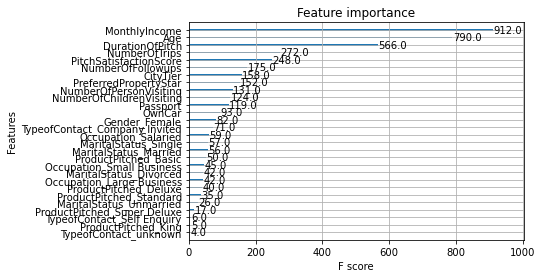

In [159]:
xgboost.plot_importance(xgb_model)

In [161]:
pred_xgby = xgb_model.predict(test)

<br>